# Assignment 2: Training and tuning a CNN on MNIST and CIFAR100
## Musab - 29409
## Hussain - 29410

# Libraries

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATA

In [16]:
# Define transformations for MNIST and CIFAR100
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_cifar100 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform_mnist, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform_mnist, download=True)

# CIFAR100 dataset
cifar_train = datasets.CIFAR100(root='./data', train=True, transform=transform_cifar100, download=True)
cifar_test = datasets.CIFAR100(root='./data', train=False, transform=transform_cifar100, download=True)

# Dataloaders
mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

cifar_train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


# FULLY CONNECTED NEURAL NETWORK

In [17]:
class FCNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU, dropout=0.0):
        super(FCNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            activation_fn(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            activation_fn(),
            nn.Dropout(dropout),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.fc(x)

# CONVOLUTIONAL NEURAL NETWORK

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 100)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# FINE-TUNING VGG MODEL

In [19]:
def fine_tune_vgg():
    # Load pre-trained VGG16
    vgg = models.vgg16(pretrained=True)

    # Freeze all layers
    for param in vgg.parameters():
        param.requires_grad = False

    # Replace last layer
    vgg.classifier[6] = nn.Linear(4096, 100)
    vgg = vgg.to(device)

    return vgg

# TRAINING AND EVALUATION

In [20]:
def train_model(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Initial learning rate

    # Initialize the scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Training
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Step the scheduler at the end of each epoch
        scheduler.step()

        # Optionally log the learning rate
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}, Learning Rate: {current_lr}")

    # Evaluation
    evaluate_model(model, test_loader)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 5-FOLD CROSS-VALIDATION

In [21]:
def k_fold_cross_validation(model_class, dataset, k=5, epochs=5, batch_size=64):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n--- Fold {fold + 1}/{k} ---")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = model_class().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train
        model.train()
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validate
        accuracy = evaluate_fold(model, val_loader)
        fold_accuracies.append(accuracy)
        print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}%")

    mean_accuracy = np.mean(fold_accuracies)
    print(f"\nMean Accuracy over {k} folds: {mean_accuracy:.2f}%")
    return mean_accuracy


def evaluate_fold(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# SAVE AND LOAD CHECKPOINTS

In [22]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")

def load_model(model, filename):
    model.load_state_dict(torch.load(filename))
    print(f"Model loaded from {filename}")

# Pipeline

In [23]:
# Train and evaluate FCNN on MNIST
fcnn = FCNN().to(device)
train_model(fcnn, mnist_train_loader, mnist_test_loader, epochs=5)

Epoch [1/5] Loss: 0.2322, Learning Rate: 0.0009045084971874737
Epoch [2/5] Loss: 0.0370, Learning Rate: 0.0006545084971874737
Epoch [3/5] Loss: 0.0930, Learning Rate: 0.00034549150281252633
Epoch [4/5] Loss: 0.0242, Learning Rate: 9.549150281252633e-05
Epoch [5/5] Loss: 0.0064, Learning Rate: 0.0
Test Accuracy: 98.04%


In [24]:
# Train and evaluate CNN on CIFAR100
cnn = CNN().to(device)
train_model(cnn, cifar_train_loader, cifar_test_loader, epochs=10)

Epoch [1/10] Loss: 2.9396, Learning Rate: 0.0009755282581475768
Epoch [2/10] Loss: 2.3303, Learning Rate: 0.0009045084971874736
Epoch [3/10] Loss: 2.2231, Learning Rate: 0.0007938926261462366
Epoch [4/10] Loss: 2.4873, Learning Rate: 0.0006545084971874737
Epoch [5/10] Loss: 0.9436, Learning Rate: 0.0005
Epoch [6/10] Loss: 1.5067, Learning Rate: 0.00034549150281252633
Epoch [7/10] Loss: 1.3293, Learning Rate: 0.0002061073738537635
Epoch [8/10] Loss: 1.0760, Learning Rate: 9.549150281252634e-05
Epoch [9/10] Loss: 0.5847, Learning Rate: 2.4471741852423235e-05
Epoch [10/10] Loss: 1.0981, Learning Rate: 0.0
Test Accuracy: 42.84%


In [25]:
# Fine-tune VGG on CIFAR100
vgg = fine_tune_vgg()
train_model(vgg, cifar_train_loader, cifar_test_loader, epochs=5)

Epoch [1/5] Loss: 3.0510, Learning Rate: 0.0009045084971874737
Epoch [2/5] Loss: 2.6375, Learning Rate: 0.0006545084971874737
Epoch [3/5] Loss: 2.5520, Learning Rate: 0.00034549150281252633
Epoch [4/5] Loss: 2.3152, Learning Rate: 9.549150281252633e-05
Epoch [5/5] Loss: 2.1227, Learning Rate: 0.0
Test Accuracy: 40.03%


In [26]:
# Perform 5-Fold Cross-Validation on MNIST using FCNN
k_fold_cross_validation(FCNN, mnist_train, k=5, epochs=5)


--- Fold 1/5 ---
Fold 1 Accuracy: 97.33%

--- Fold 2/5 ---
Fold 2 Accuracy: 96.88%

--- Fold 3/5 ---
Fold 3 Accuracy: 96.77%

--- Fold 4/5 ---
Fold 4 Accuracy: 96.55%

--- Fold 5/5 ---
Fold 5 Accuracy: 96.53%

Mean Accuracy over 5 folds: 96.81%


96.80999999999999

In [27]:
# Save and load model checkpoints
save_model(fcnn, "fcnn_mnist.pth")

Model saved to fcnn_mnist.pth


In [28]:
# Save and load model checkpoints
save_model(fcnn, "cnn_cifar.pth")

Model saved to cnn_cifar.pth


In [29]:
# Save and load model checkpoints
save_model(fcnn, "vgg_cifar.pth")

Model saved to vgg_cifar.pth


In [30]:
load_model(fcnn, "fcnn_mnist.pth")

Model loaded from fcnn_mnist.pth


<ipython-input-22-f137722574dd>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


In [31]:
load_model(fcnn, "cnn_cifar.pth")

Model loaded from cnn_cifar.pth


<ipython-input-22-f137722574dd>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


In [32]:
load_model(fcnn, "vgg_cifar.pth")

Model loaded from vgg_cifar.pth


<ipython-input-22-f137722574dd>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


# Visualizing

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [34]:
def evaluate_model_with_visualization(model, test_loader, num_images=10):
    model.eval()
    correct = 0
    total = 0
    images_shown = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Visualize predictions
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                # Show the image and its prediction
                image = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
                image = image * 0.5 + 0.5  # De-normalize
                plt.imshow(image)
                plt.title(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
                plt.axis("off")
                plt.show()
                images_shown += 1
            if images_shown >= num_images:
                break

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [35]:
def visualize_misclassifications(model, test_loader, num_images=10):
    model.eval()  # Set the model to evaluation mode
    images_shown = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                if predicted[i] != labels[i]:  # Check for misclassification
                    # Display the image
                    image = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
                    image = image * 0.5 + 0.5  # De-normalize
                    plt.imshow(image)
                    plt.title(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
                    plt.axis("off")
                    plt.show()

                    images_shown += 1

            if images_shown >= num_images:
                break

In [36]:
def evaluate_model_for_plotting(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [37]:
def visualize_feature_maps(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        for name, layer in model.conv.named_children():
            image = layer(image)
            if isinstance(layer, nn.ReLU):  # Visualize after activation
                feature_maps = image.cpu().squeeze(0)  # Remove batch dimension
                fig, axes = plt.subplots(1, min(8, feature_maps.size(0)), figsize=(15, 5))
                for i in range(min(8, feature_maps.size(0))):  # Visualize up to 8 filters
                    axes[i].imshow(feature_maps[i].detach().numpy(), cmap="viridis")
                    axes[i].axis("off")
                plt.suptitle(f"Feature Maps after {name}")
                plt.show()

In [38]:
def plot_confusion_matrix(model, test_loader, class_names):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="viridis", xticks_rotation=45)
    plt.show()

In [32]:
# Visualize predictions for MNIST
evaluate_model_with_visualization(fcnn, mnist_test_loader, num_images=10)

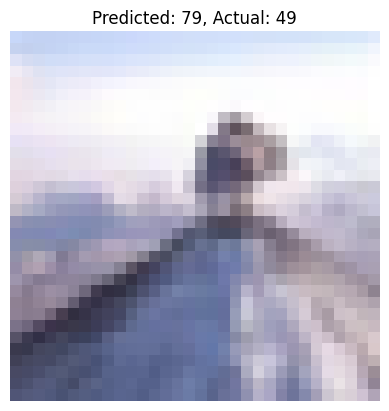

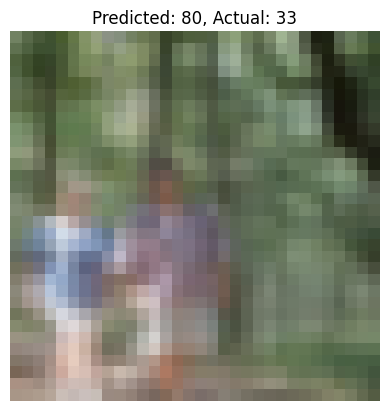

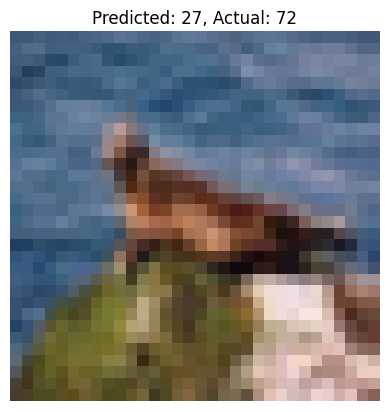

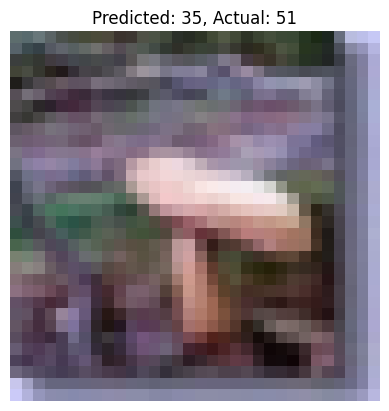

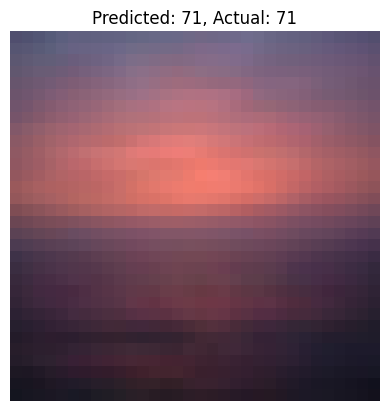

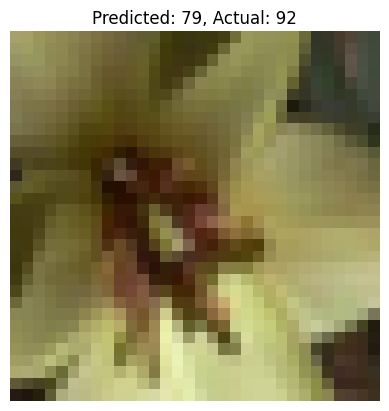

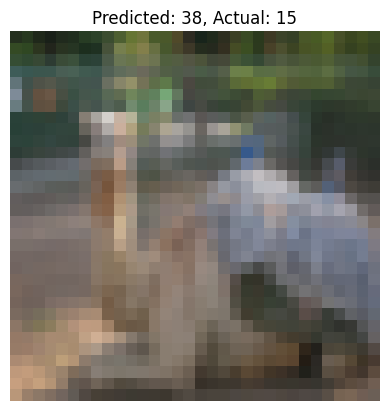

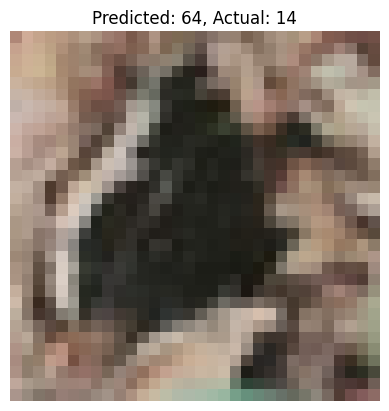

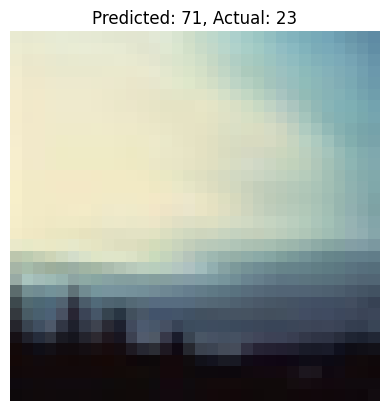

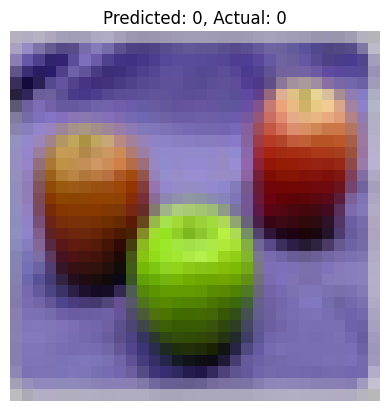

Test Accuracy: 40.62%


In [39]:
# Visualize predictions for CIFAR100
evaluate_model_with_visualization(cnn, cifar_test_loader, num_images=10)

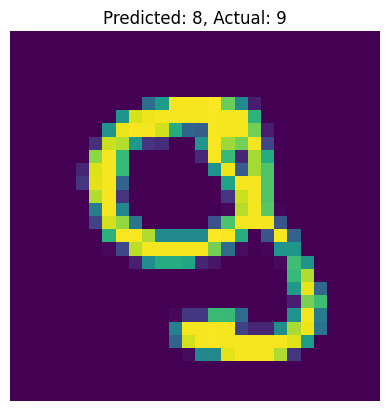

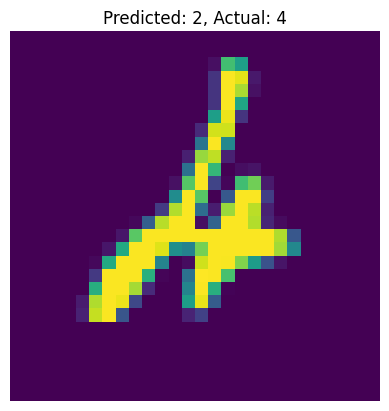

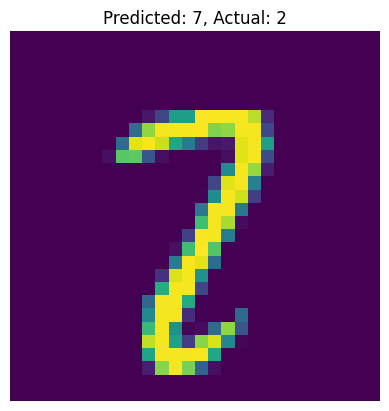

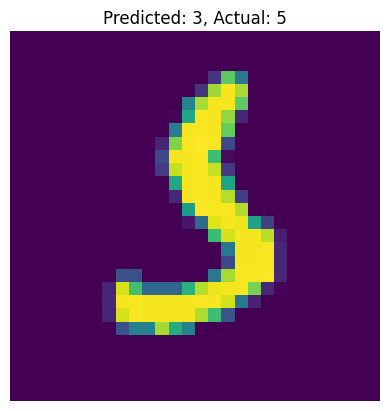

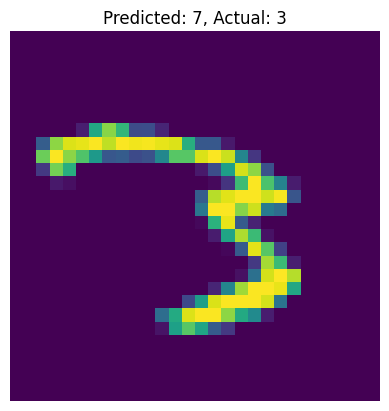

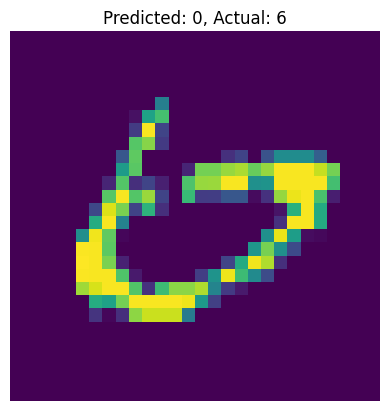

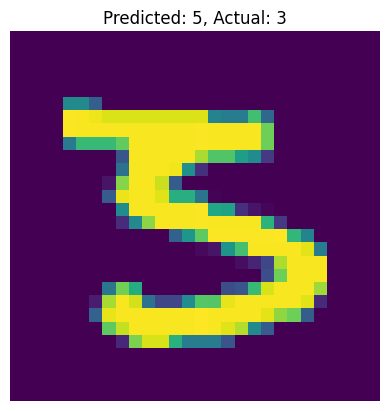

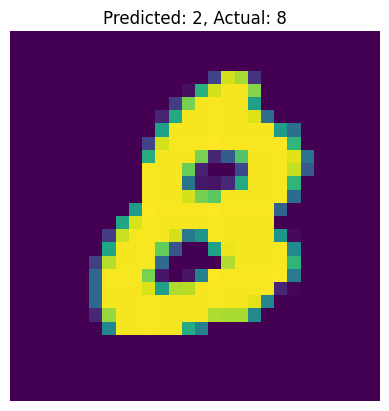

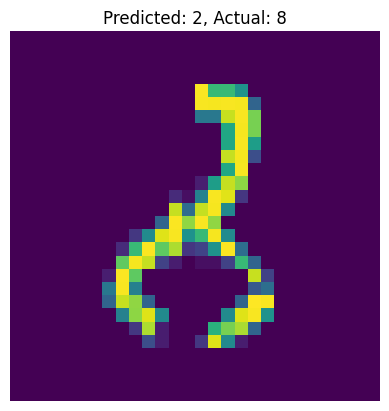

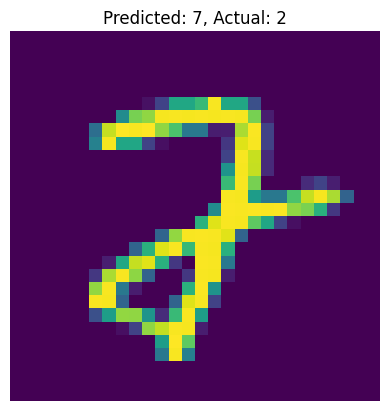

In [40]:
# Visualize misclassified examples for MNIST
visualize_misclassifications(fcnn, mnist_test_loader, num_images=10)

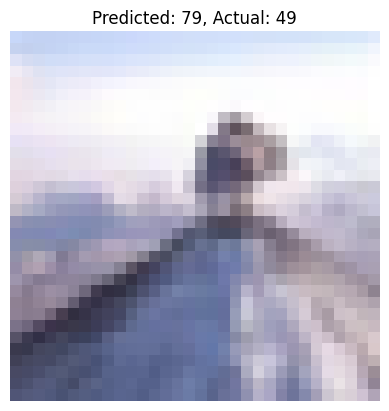

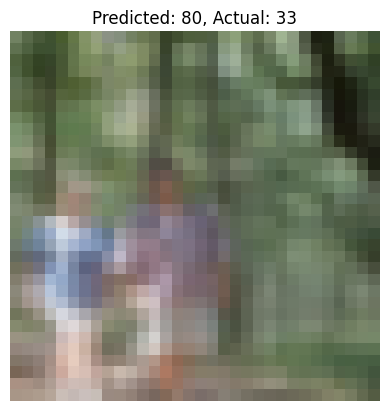

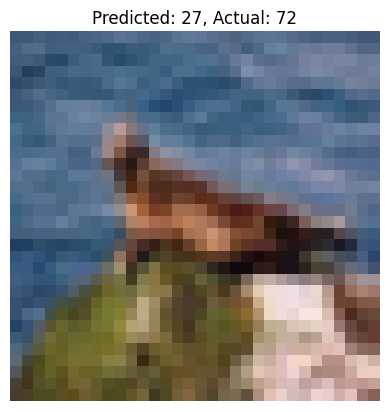

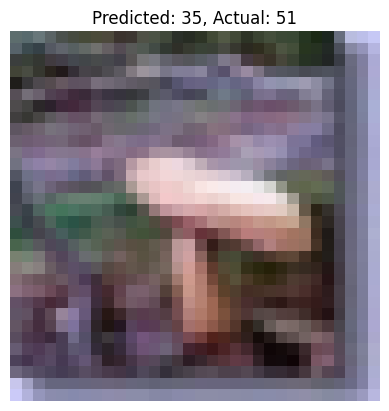

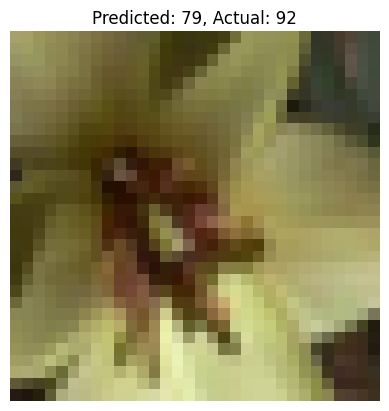

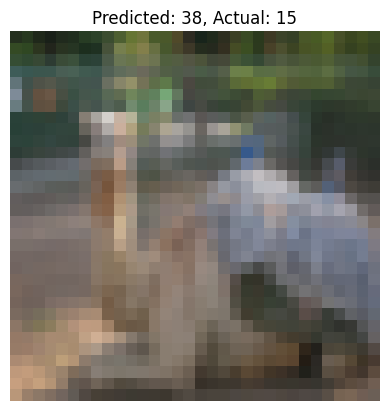

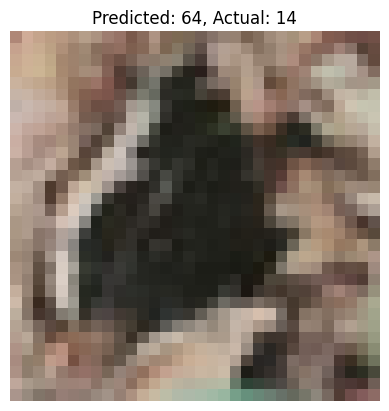

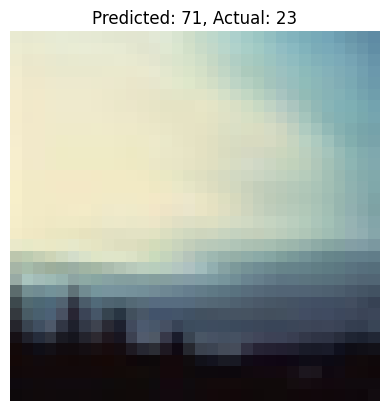

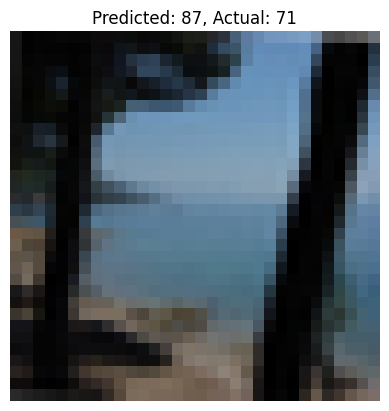

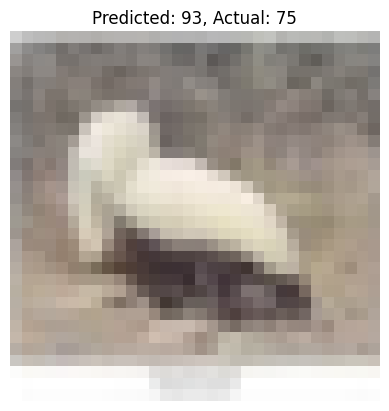

In [41]:
# Visualize misclassified examples for CIFAR100
visualize_misclassifications(cnn, cifar_test_loader, num_images=10)

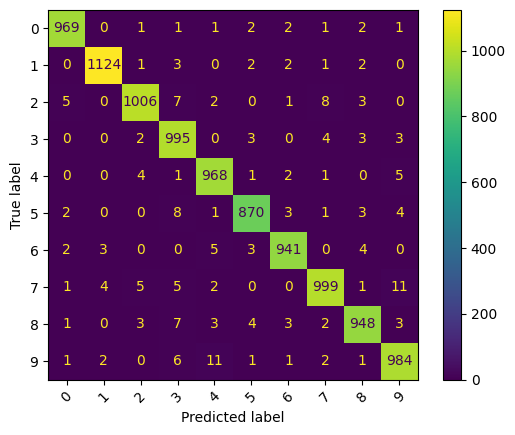

In [42]:
# Plot confusion matrix for MNIST
plot_confusion_matrix(fcnn, mnist_test_loader, class_names=[str(i) for i in range(10)])

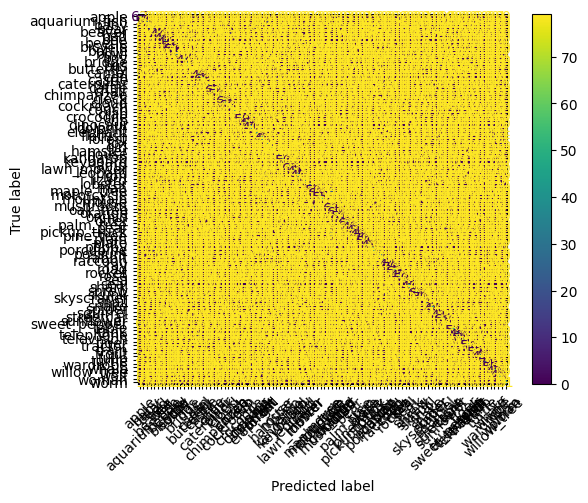

In [43]:
# Plot confusion matrix for CIFAR100
plot_confusion_matrix(cnn, cifar_test_loader, class_names=cifar_train.classes)

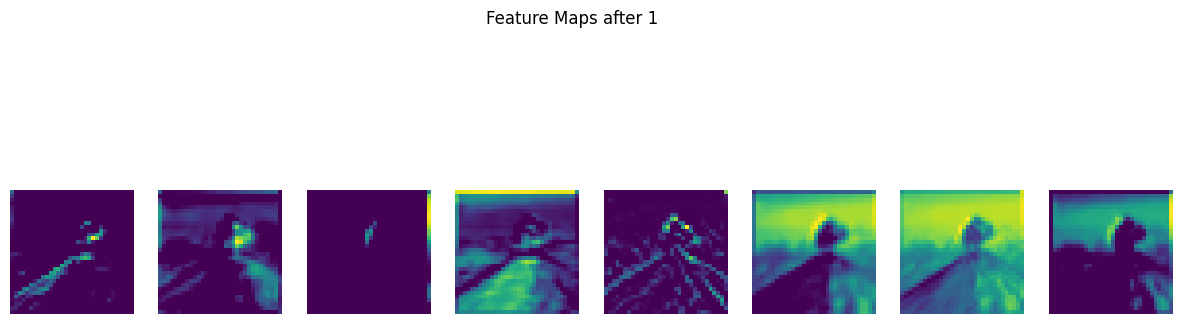

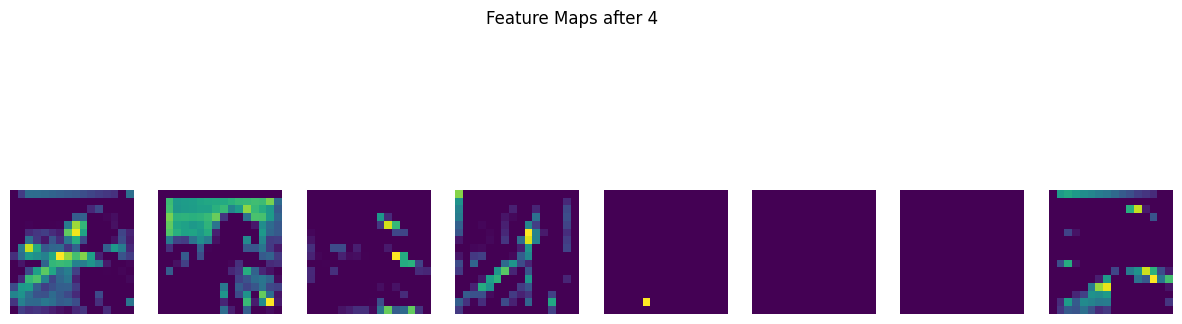

In [44]:
# Pick a sample image from CIFAR100
sample_image, _ = cifar_test[0]  # First test image
visualize_feature_maps(cnn, sample_image)

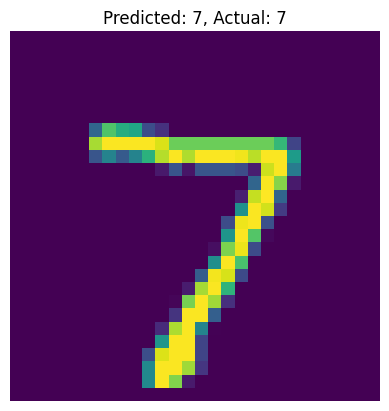

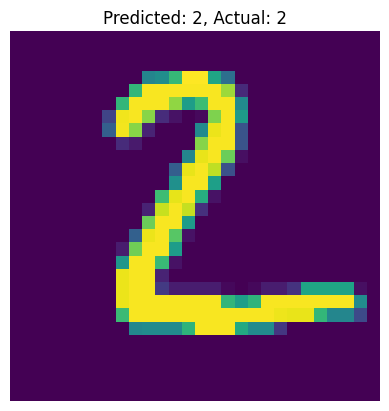

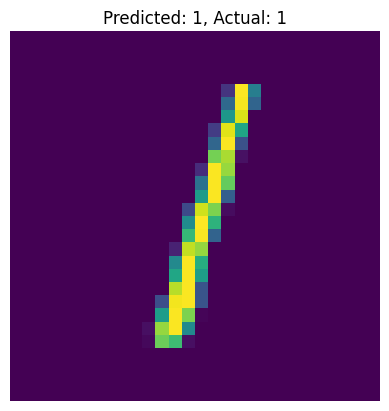

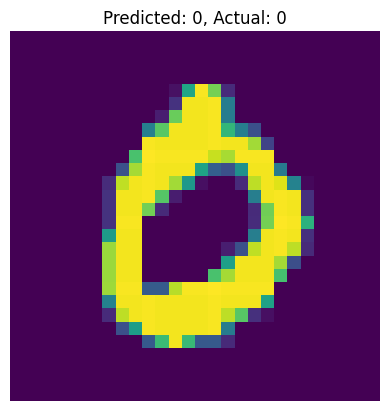

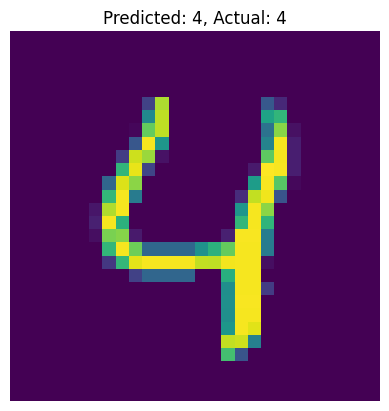

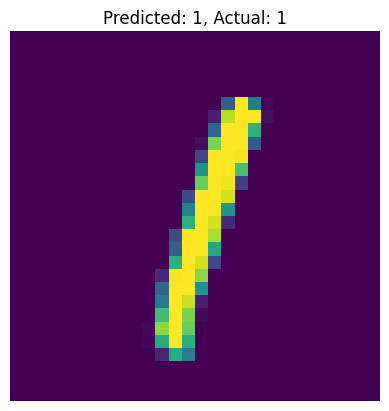

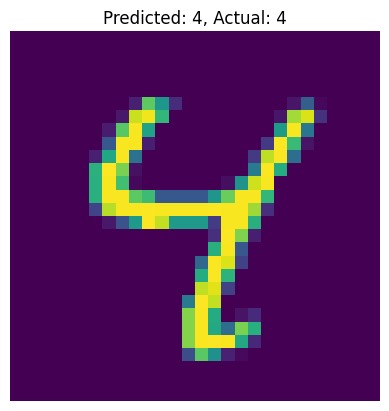

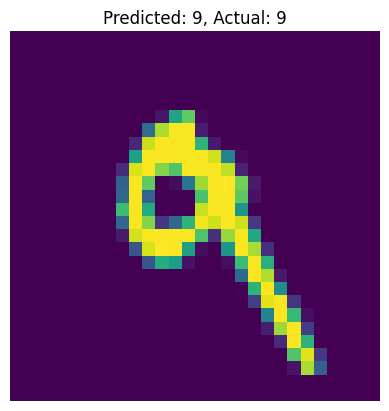

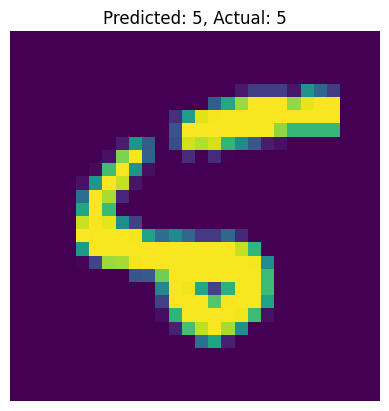

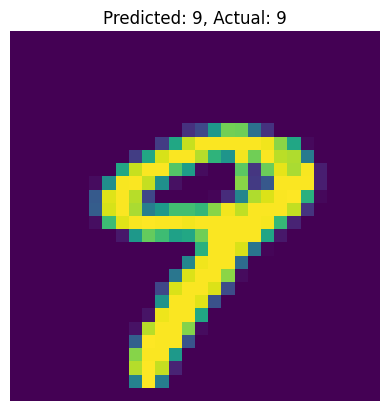

Test Accuracy: 100.00%


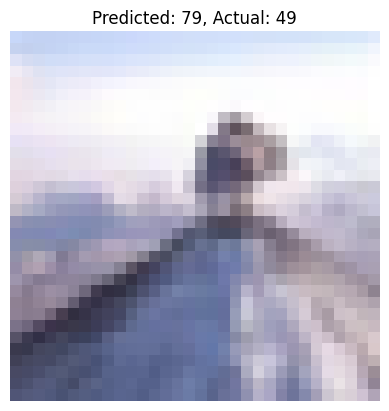

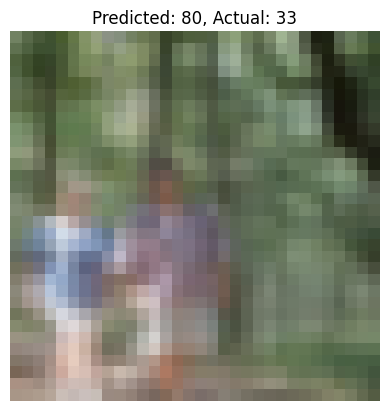

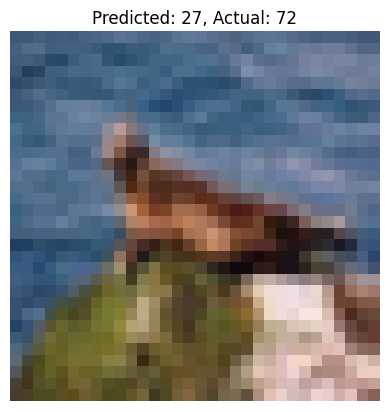

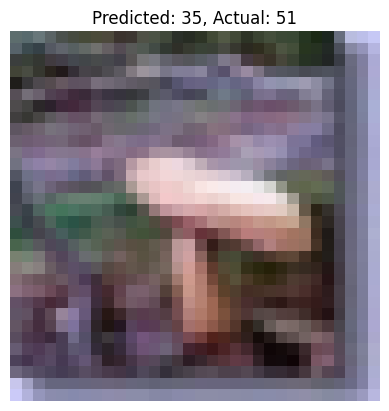

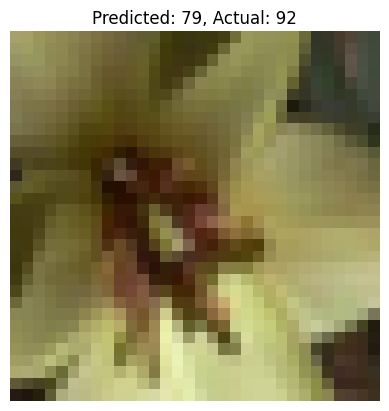

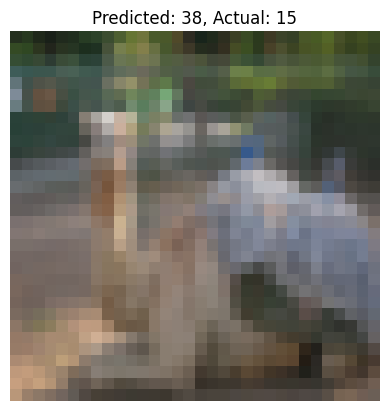

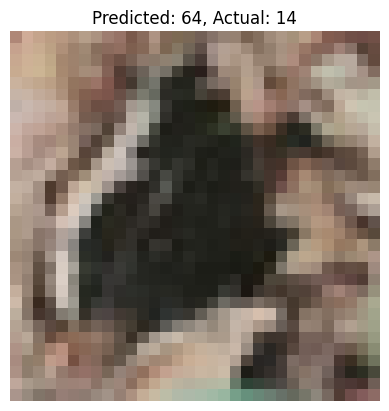

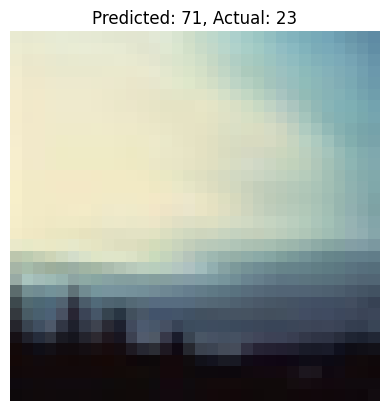

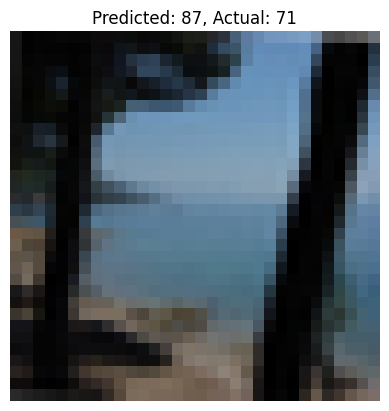

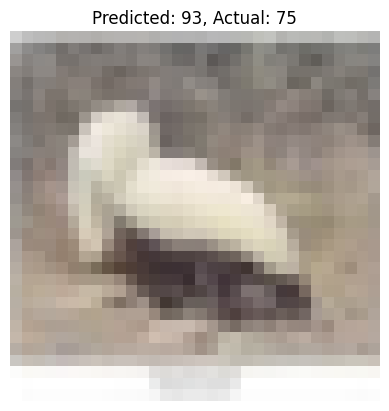

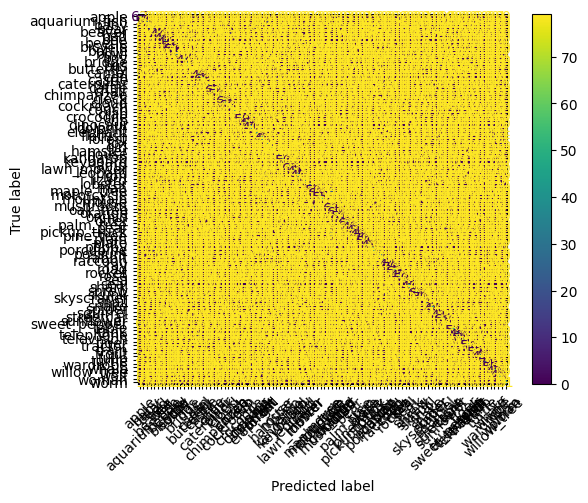

In [45]:
evaluate_model_with_visualization(fcnn, mnist_test_loader, num_images=10)
visualize_misclassifications(cnn, cifar_test_loader, num_images=10)
plot_confusion_matrix(cnn, cifar_test_loader, class_names=cifar_train.classes)

# Fixed code for CIFAR

In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 100)  # Change to 100 for CIFAR100
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [47]:
def fine_tune_vgg():
    # Load pre-trained VGG16
    vgg = models.vgg16(pretrained=True)

    # Freeze all layers
    for param in vgg.parameters():
        param.requires_grad = False

    # Replace the last layer with 100 classes
    vgg.classifier[6] = nn.Linear(4096, 100)
    vgg = vgg.to(device)

    return vgg

In [48]:
# Print a few CIFAR100 sample labels
for images, labels in cifar_test_loader:
    print(labels[:10])  # Should print numbers between 0 and 99
    break

tensor([49, 33, 72, 51, 71, 92, 15, 14, 23,  0])


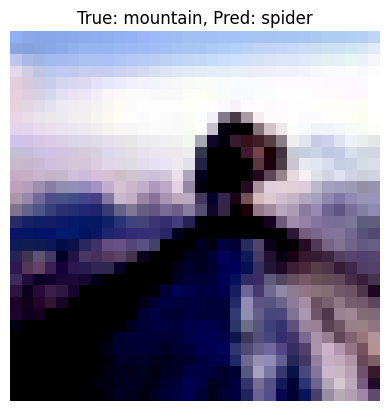

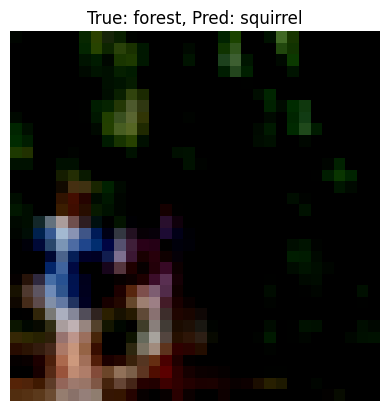

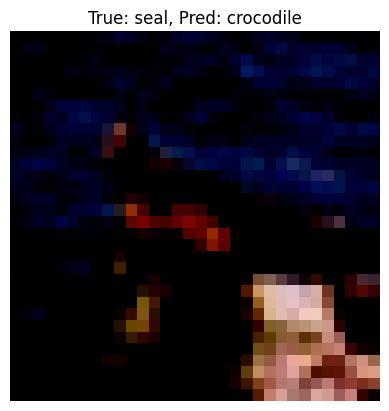

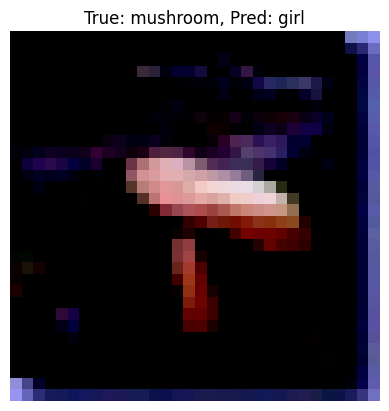

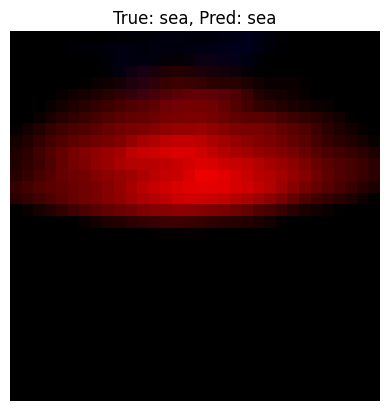

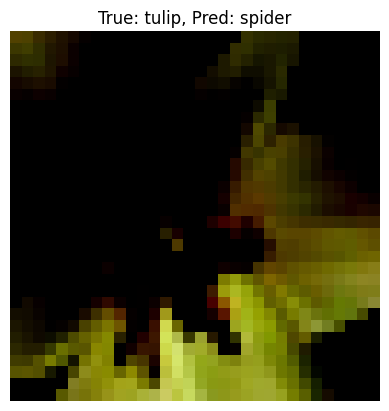

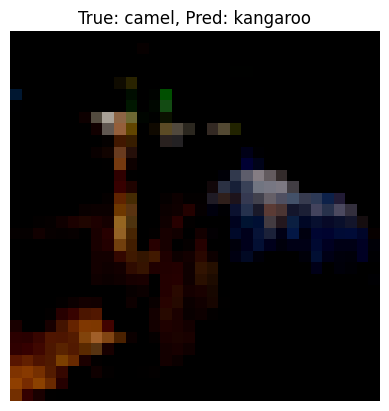

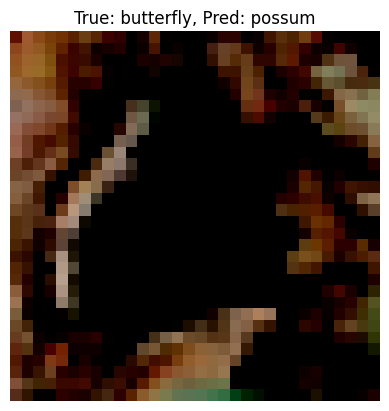

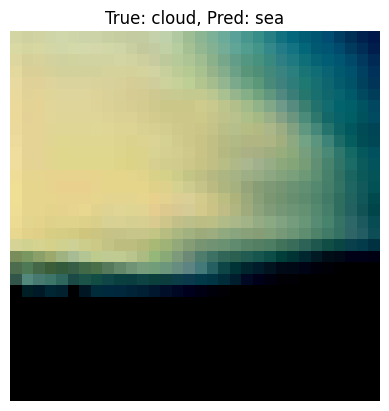

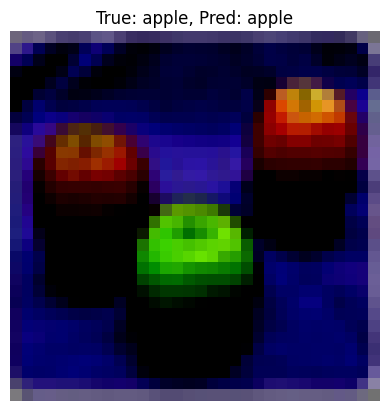

In [49]:
def visualize_predictions(model, test_loader, class_names, num_images=10):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return
                plt.imshow(images[i].cpu().permute(1, 2, 0))  # Convert image to HxWxC
                plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[predicted[i]]}")
                plt.axis("off")
                plt.show()
                images_shown += 1

# CIFAR100 class names
cifar_classes = cifar_train.classes

# Visualize predictions
visualize_predictions(cnn, cifar_test_loader, cifar_classes, num_images=10)
